# Practice7 logP GGNN  

#### Recommend to view on Github -> https://github.com/heartcored98/CH485_AI_Chemistry/blob/master/Practice7_logP_GGNN/Practice7_logP_GGNN.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm
from pprint import pprint

import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import Field, RawField, NestedField, TabularDataset, BucketIterator
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from utils import *
from visual_tool import *

from tensorboardX import SummaryWriter



parser = argparse.ArgumentParser()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


# 1. Prepare Dataset  

Following function read zinc.smiles and convert all the smiles into X, A tensors.  

In [26]:
partition = make_partition(100000, 0.1, 0.1, 123)

# 2. Model Architecture

In [35]:
class BN1d(nn.Module):
    def __init__(self, out_dim):
        super(BN1d, self).__init__()
        self.bn = nn.BatchNorm1d(out_dim)
             
    def forward(self, x):
        origin_shape = x.shape
        x = x.view(-1, origin_shape[-1])
        x = self.bn(x)
        x = x.view(origin_shape)
        return x
    
    
class GGNN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, norm_type, skip_connection):
        super(GGNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.norm_type = norm_type
        self.skip_connection = skip_connection
    
        self.projection = nn.Sequential() if self.input_dim == self.hidden_dim else nn.Linear(self.input_dim, self.hidden_dim, bias=False)
        self.zw = nn.Linear(hidden_dim, hidden_dim)
        self.zu = nn.Linear(hidden_dim, hidden_dim)
        self.rw = nn.Linear(hidden_dim, hidden_dim)
        self.ru = nn.Linear(hidden_dim, hidden_dim)
        self.w = nn.Linear(hidden_dim, hidden_dim)
        self.u = nn.Linear(hidden_dim, hidden_dim)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        # Define Normalization layer
        if self.norm_type == 'bn':
            self.norm = BN1d(self.hidden_dim)
        elif self.norm_type == 'ln':
            self.norm = nn.LayerNorm(self.hidden_dim)
        else:
            self.norm = nn.Sequential()
            
        self.init_params()
        
    def forward(self, X, A):
        _X = self.projection(X)
        _m = torch.matmul(A, _X)
        
        # x_t : _m, h_t-1 : _X
        zt = self.sigmoid(self.zw(_m) + self.zu(_X))
        rt = self.sigmoid(self.rw(_m) + self.ru(_X))
        h_tt = self.tanh(self.w(_m) + rt * self.u(_X))
        h_t = zt * _X + (1 - zt) * h_tt
        if self.skip_connection:
            h_t = _X + h_t
        h_t = self.norm(h_t)
        return h_t, A
        
    def init_params(self):
        nn.init.xavier_normal_(self.zw.weight.data)
        nn.init.xavier_normal_(self.zu.weight.data)
        nn.init.xavier_normal_(self.rw.weight.data)
        nn.init.xavier_normal_(self.ru.weight.data)
        nn.init.xavier_normal_(self.w.weight.data)
        nn.init.xavier_normal_(self.u.weight.data)
    
    
class EncoderGGNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, reg_dim, output_dim=1,
                 num_layers=2, dropout=0.1, 
                 emb_train=True, skip_connection=True, 
                 norm_type='ln'):
        
        super(EncoderGGNN, self).__init__()
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.reg_dim = reg_dim
        self.output_dim = output_dim
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.emb_train = emb_train
        self.skip_connection = skip_connection    
        self.norm_type = norm_type
        
        # Define embedding layer
        self.embedding = self.create_emb_layer(self.vocab_size, self.emb_train)
    
        # Define the Recurrent layer
        self.ggnns = nn.ModuleList()
        self.ggnns.append(GGNN(self.emb_dim, self.hidden_dim, self.norm_type, self.skip_connection))
        for i in range(self.num_layers-1):
            self.ggnns.append(GGNN(self.hidden_dim, self.hidden_dim, self.norm_type, self.skip_connection))
            
        # Define the output layer
        self.fc1 = nn.Linear(self.hidden_dim, self.reg_dim)
        self.fc2 = nn.Linear(self.reg_dim , self.reg_dim // 2)
        self.fc3 = nn.Linear(self.reg_dim // 2, self.output_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X, A):
        X = self._embed(X)
        for ggnn in self.ggnns:
            X, A = ggnn(X, A)
        
        readout_X = self.sigmoid(torch.sum(X, dim=1))
        molvec = self.dropout(self.relu(self.fc1(readout_X)))
        molvec = self.dropout(self.relu(self.fc2(molvec)))
        molvec = self.fc3(molvec)
        return molvec.squeeze()
    
    def _embed(self, x):
        embed_x = self.embedding(x[:,:,0])
        x = torch.cat((embed_x, x[:,:,1:].float()), 2)
        return x 
    
    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# 3. Train & Validation

In [38]:
def train(model, partition, optimizer, criterion, args, **kwargs):
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=True,
        pin_memory=True,
    )
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    
    for batch_idx, batch in enumerate(data_iter):
        input_X, input_A, true_logp = torch.Tensor(batch[0].float()).long(), torch.Tensor(batch[1].float()), torch.Tensor(batch[2].float())
        input_X, input_A, true_logp = input_X.to(args.device), input_A.to(args.device), true_logp.to(args.device)

        model.train()
        optimizer.zero_grad()

        pred_logp = model(input_X, input_A)        
        train_loss = criterion(pred_logp, true_logp)        
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        cnt_iter += 1
        args.bar.update(input_X.shape[0])

    return model, list_train_loss


def validate(model, partition, criterion, args):
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.batch_size,
        shuffle=False,
        pin_memory=True,
    )

    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        with torch.no_grad():
            input_X, input_A, true_logp = torch.Tensor(batch[0].float()).long(), torch.Tensor(batch[1].float()), torch.Tensor(batch[2].float())
            input_X, input_A, true_logp = input_X.to(args.device), input_A.to(args.device), true_logp.to(args.device)

            model.eval()

            pred_logp = model(input_X, input_A)        
            val_loss = criterion(pred_logp, true_logp)        
            epoch_val_loss += val_loss.item()
            cnt_iter += 1

    return epoch_val_loss/cnt_iter


def test(model, data_iter, args, **kwargs):
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.test_batch_size,
        shuffle=False,
        pin_memory=True,
    )  

    list_y, list_pred_y = list(), list()

    for batch_idx, batch in enumerate(data_iter):
        with torch.no_grad():
            input_X, input_A, true_logp = torch.Tensor(batch[0].float()).long(), torch.Tensor(batch[1].float()), torch.Tensor(batch[2].float())
            input_X, input_A, true_logp = input_X.to(args.device), input_A.to(args.device), true_logp.to(args.device)

            model.eval()

            pred_logp = model(input_X, input_A)

            list_y += true_logp.cpu().detach().numpy().tolist()
            list_pred_y += pred_logp.cpu().detach().numpy().tolist()
            args.bar.update(input_X.shape[0])

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()

    # ===== Construct Model ===== #
    model = EncoderGGNN(args.vocab_size, 58, args.hidden_dim, args.reg_dim, output_dim=1,
                     num_layers=args.n_layer, dropout=args.dropout, 
                     emb_train=args.emb_train, skip_connection=args.skip_connection, 
                     norm_type=args.norm_type)

    model.to(args.device)
    criterion = nn.MSELoss().to(args.device)
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    overall_params = sum(p.numel() for p in model.parameters())

#     print("##############################################")
#     print("Total Model Parameters : {}".format(trainable_params))
    print("Trainable   Parameters : {}".format(overall_params))
#     print("##############################################")
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
#     print("{} Optimizer is Constructed".format(str(optimizer)))
#     print("##############################################")

    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition, optimizer, criterion, args, **{'epoch':epoch})
        val_loss = validate(model, partition, criterion, args)
        mae, std, true_y, pred_y = test(model, partition, args, **{'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

# Experiment.1 Learning rate vs Hidden Dim

In [39]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp1_lr_hidden_dim'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 2
args.hidden_dim = 128
args.reg_dim = 128
args.output_dim = 1
args.vocab_size = 40

args.dropout = 0.1
args.emb_train = False
args.skip_connection = True
args.norm_type = 'None'

args.lr = 0.01
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 10
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'skip_connection', 
                               'norm_type', 'epoch', 'l2_coef', 'lr'])



# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [ 0.0001, 0.001, 0.002] #[0.0006, 0.001, 0.002, 0.003] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [2, 3, 4] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.lr = var1
        args.n_layer = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 232001
[Exp  1] got mae: 0.226, std: 0.322 at epoch 10 took 57.1sec
Trainable   Parameters : 232001
[Exp  2] got mae: 0.160, std: 0.235 at epoch 10 took 56.3sec
Trainable   Parameters : 232001
[Exp  3] got mae: 0.166, std: 0.241 at epoch 10 took 56.1sec
Trainable   Parameters : 331073
[Exp  4] got mae: 0.196, std: 0.290 at epoch 10 took 68.9sec
Trainable   Parameters : 331073
[Exp  5] got mae: 0.144, std: 0.214 at epoch 10 took 69.1sec
Trainable   Parameters : 331073
[Exp  6] got mae: 0.156, std: 0.219 at epoch 10 took 69.1sec
Trainable   Parameters : 430145
[Exp  7] got mae: 0.175, std: 0.258 at epoch 10 took 81.1sec
Trainable   Parameters : 430145
[Exp  8] got mae: 0.153, std: 0.222 at epoch 10 took 82.0sec
Trainable   Parameters : 430145
[Exp  9] got mae: 0.131, std: 0.192 at epoch 10 took 82.0sec


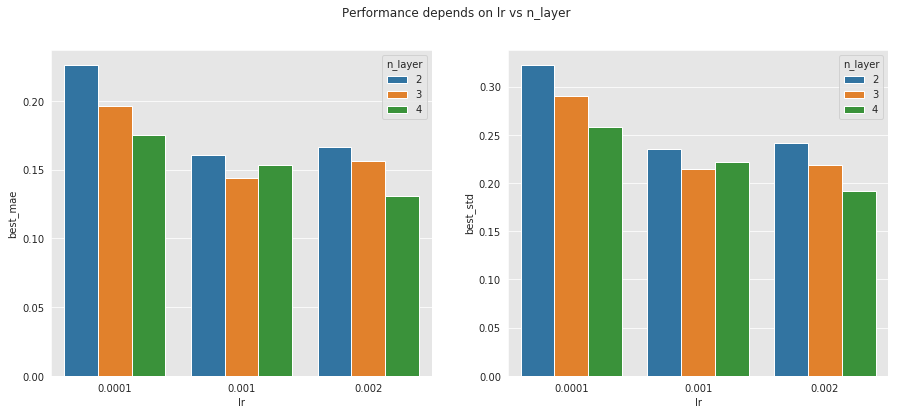

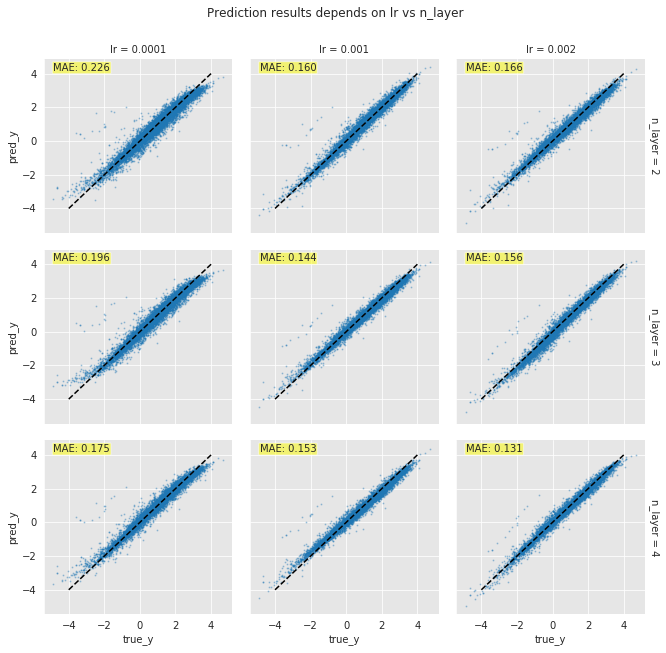

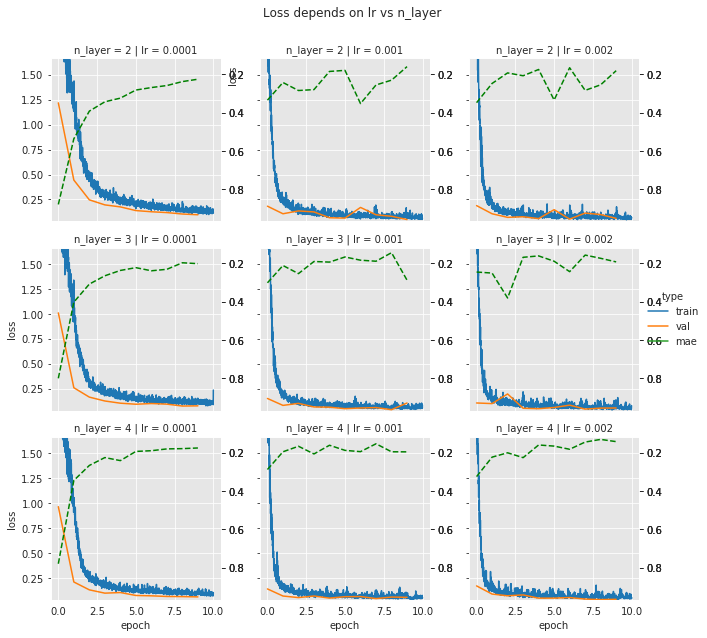

In [40]:
 
results = writer.read(exp_name='exp1_lr_hidden_dim')

variable2 = 'n_layer'
variable1 = 'lr'

plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9, quantile=0.98)

plt.show()


# Experiment.2 Learning rate vs N layer

In [41]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp2_hidden_dim_reg_dim'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 4
args.hidden_dim = 64
args.reg_dim = 256
args.output_dim = 1
args.vocab_size = 40

args.dropout = 0.1
args.emb_train = False
args.skip_connection = True
args.norm_type = 'None'

args.lr = 0.002
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 30
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'skip_connection', 
                               'norm_type', 'epoch', 'l2_coef', 'lr', 'reg_dim'])



# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [ 32, 64, 128, 256] #[0.0006, 0.001, 0.002, 0.003] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = [32, 64, 128, 256] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.hidden_dim = var1
        args.reg_dim = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 30401
[Exp  1] got mae: 0.111, std: 0.167 at epoch 30 took 162.7sec
Trainable   Parameters : 107777
[Exp  2] got mae: 0.110, std: 0.169 at epoch 30 took 192.7sec
Trainable   Parameters : 409985
[Exp  3] got mae: 0.111, std: 0.162 at epoch 30 took 244.8sec
Trainable   Parameters : 1604225
[Exp  4] got mae: 0.110, std: 0.161 at epoch 30 took 385.2sec
Trainable   Parameters : 33025
[Exp  5] got mae: 0.111, std: 0.168 at epoch 30 took 162.8sec
Trainable   Parameters : 111425
[Exp  6] got mae: 0.109, std: 0.158 at epoch 30 took 189.3sec
Trainable   Parameters : 415681
[Exp  7] got mae: 0.111, std: 0.171 at epoch 30 took 245.2sec
Trainable   Parameters : 1614017
[Exp  8] got mae: 0.104, std: 0.154 at epoch 30 took 384.9sec
Trainable   Parameters : 41345
[Exp  9] got mae: 0.124, std: 0.185 at epoch 30 took 162.8sec
Trainable   Parameters : 121793
[Exp 10] got mae: 0.101, std: 0.152 at epoch 30 took 185.5sec
Trainable   Parameters : 430145
[Exp 11] got mae: 0.100, std:

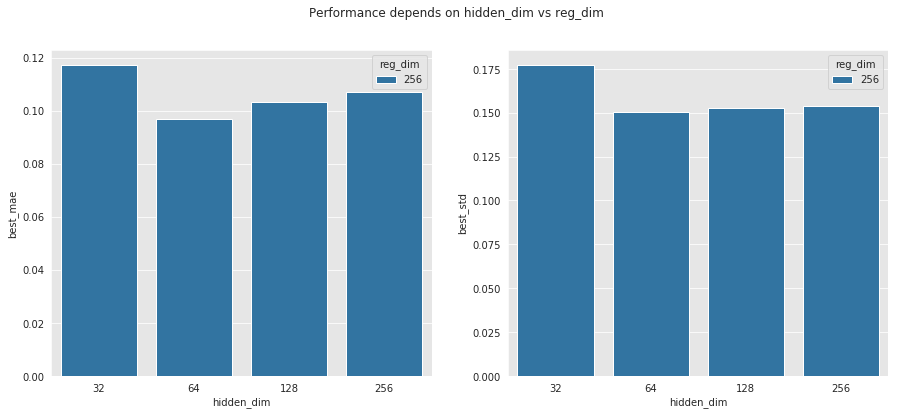

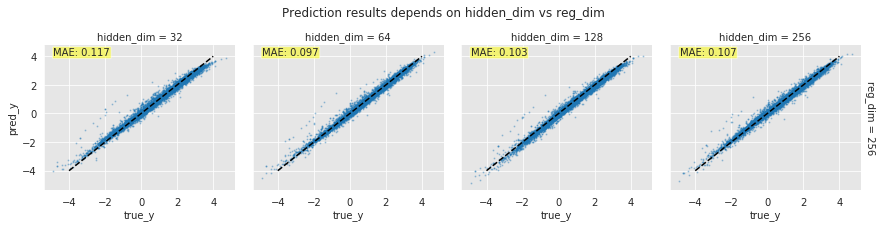

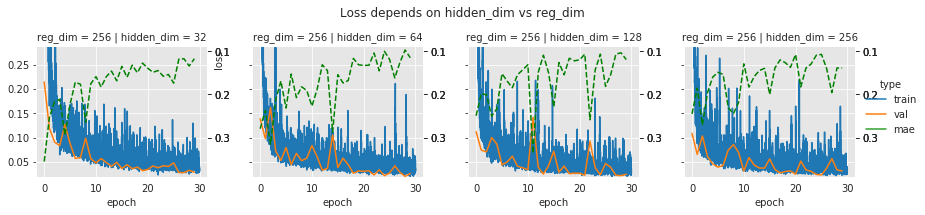

In [46]:
 
results = writer.read(exp_name='exp2_hidden_dim_reg_dim')

variable1 = 'hidden_dim'
variable2 = 'reg_dim'

plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp2_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Prediction {} vs {}'.format(variable1, variable2), top=0.8)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp2_Loss {} vs {}'.format(variable1, variable2), top=0.8, quantile=0.98)

plt.show()


# Experiment.3 Embedding Training vs Normalization Method

In [47]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

exp_name = 'exp3_emb_train_norm_type'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 4
args.hidden_dim = 64
args.reg_dim = 256
args.output_dim = 1
args.vocab_size = 40

args.dropout = 0.1
# args.emb_train = False
args.skip_connection = True
# args.norm_type = 'None'

args.lr = 0.002
args.l2_coef = 0.001
args.optim = 'ADAM'
args.epoch = 30
args.batch_size= 512
args.test_batch_size= 512
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'hidden_dim', 'output_dim', 
                               'dropout', 'emb_train', 'skip_connection', 
                               'norm_type', 'epoch', 'l2_coef', 'lr'])



# ===== Set Up experiment variable ===== #
# Define Hyperparameter Search Space
list_var1 = [True, False] #[0.0006, 0.001, 0.002, 0.003] #,2,3,4] #, False]#, 2, 3, 4]#, 4, 8]#[0.01, 0.001, 0.0001, 0.00001]
list_var2 = ['None', 'bn', 'ln'] #, 2, 3]#,2,3] #[10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]

n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_var1)*len(list_var2)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))


# ===== Conduct Experiment ===== #
writer.clear(exp_name)
for var2 in list_var2:
    for var1 in list_var1:
        ts = time.time()
        args.emb_train = var1
        args.norm_type = var2
        
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))
    

Trainable   Parameters : 154817
[Exp  1] got mae: 0.102, std: 0.158 at epoch 30 took 231.6sec
Trainable   Parameters : 154817
[Exp  2] got mae: 0.103, std: 0.157 at epoch 30 took 186.6sec
Trainable   Parameters : 155329
[Exp  3] got mae: 0.070, std: 0.101 at epoch 30 took 326.3sec
Trainable   Parameters : 155329
[Exp  4] got mae: 0.081, std: 0.127 at epoch 30 took 272.7sec
Trainable   Parameters : 155329
[Exp  5] got mae: 0.078, std: 0.119 at epoch 30 took 242.7sec
Trainable   Parameters : 155329
[Exp  6] got mae: 0.086, std: 0.125 at epoch 30 took 213.3sec


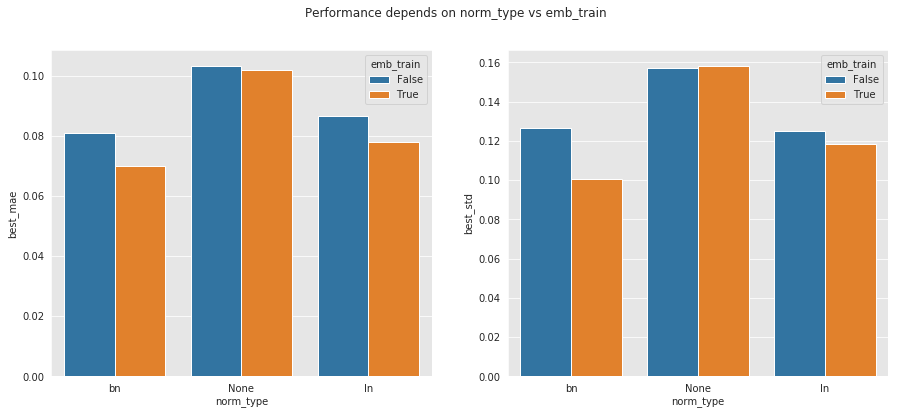

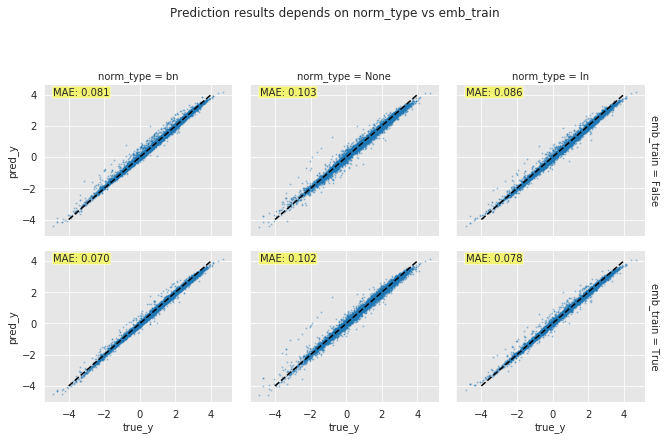

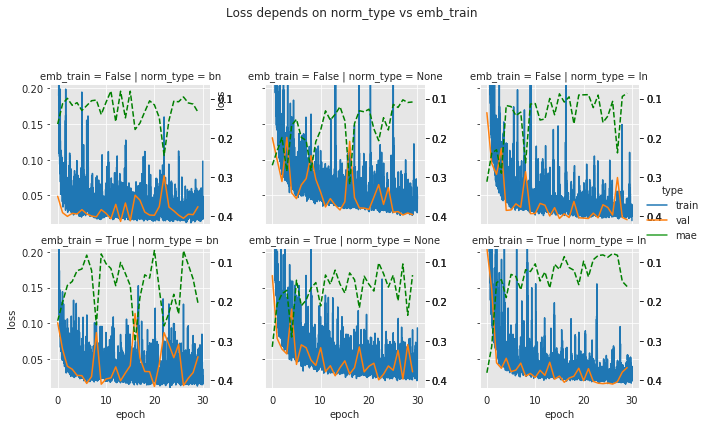

In [49]:
 
results = writer.read(exp_name='exp3_emb_train_norm_type')

variable2 = 'emb_train'
variable1 = 'norm_type'

plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp3_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 'best_mae',
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp3_Prediction {} vs {}'.format(variable1, variable2), top=0.8)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp3_Loss {} vs {}'.format(variable1, variable2), top=0.8, quantile=0.98)

plt.show()
